In [127]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split



In [128]:
import sys
import os

# Get the parent directory of the current file (notebook)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the parent directory to sys.path
sys.path.append(parent_dir)
from infra.data_loader import DataLoader
data_loader_test = DataLoader('')
content = data_loader_test._read_docx(f'{parent_dir}/Data/תיאור התמונות.docx')
data = data_loader_test._extract_data(content)

distances_df = pd.read_csv(f"{parent_dir}/Data/ground_truth_distances.csv")

In [129]:
ground_truth_df = pd.DataFrame([data])
ground_truth_df

,תמונה 1,תמונה 2,תמונה 3,תמונה 4,תמונה 5,תמונה 6,תמונה 7,תמונה 8,תמונה 9,תמונה 10,תמונה 11,תמונה 12,תמונה 13,תמונה 14
0,ילד יושב ליד שולחן ומביט בכינור המוצב על השולח...,"סצנה כפרית עם אישה מחזיקה ספר בחזית. ברקע, גבר...",ילד מצטופף ליד ספה. על הרצפה לידו נמצא חפץ דו-...,אישה אוחזת בכתפיו של גבר שפונה ממנה.,אישה מביטה לתוך חדר מסף דלת.,אישה מבוגרת עומדת במקביל לחלון. מאחוריה גבר צע...,ילדה צעירה יושבת על ספה ומחזיקה בובה בידיה. מא...,ילד צעיר בחזית בוהה ישירות מחוץ לתמונה. ברקע ת...,ארבעה גברים בשדה שוכבים זה מול זה.,אדם אחד מחזיק את ראשו כנגד כתפו של אדם אחר. מי...,אדם עם ידו מורמת עומד מעל ילד השוכב על מיטה בע...,ילד יושב בפתח של בקתת עץ.,צללית של אדם מול חלון,אישה עומדת ליד דלת פתוחה כשיד אחת אוחזת בצד הד...


In [130]:
distances_df.head()

,תמונה 1,תמונה 2,תמונה 3,תמונה 4,תמונה 5,תמונה 6,תמונה 7,תמונה 8,תמונה 9,תמונה 10,תמונה 11,תמונה 12,תמונה 13,תמונה 14,label
0,0.566962,0.585865,0.654433,0.522563,0.516626,0.628582,0.669026,0.661970,0.587222,0.572410,0.614919,0.600058,0.549366,0.589052,0
1,0.525855,0.631806,0.580592,0.549768,0.557294,0.536219,0.681729,0.648934,0.599493,0.605749,0.527505,0.592921,0.519440,0.609815,0
2,0.542138,0.628878,0.622527,0.510161,0.540840,0.616226,0.648178,0.661126,0.626442,0.633731,0.600327,0.580142,0.526667,0.624867,0
3,0.577814,0.577623,0.697502,0.492824,0.459957,0.580962,0.602264,0.627524,0.551496,0.565675,0.540799,0.611534,0.424131,0.544731,0
4,0.520636,0.515395,0.502712,0.499289,0.498142,0.578297,0.633887,0.670567,0.551784,0.614365,0.550647,0.596818,0.517766,0.585009,0


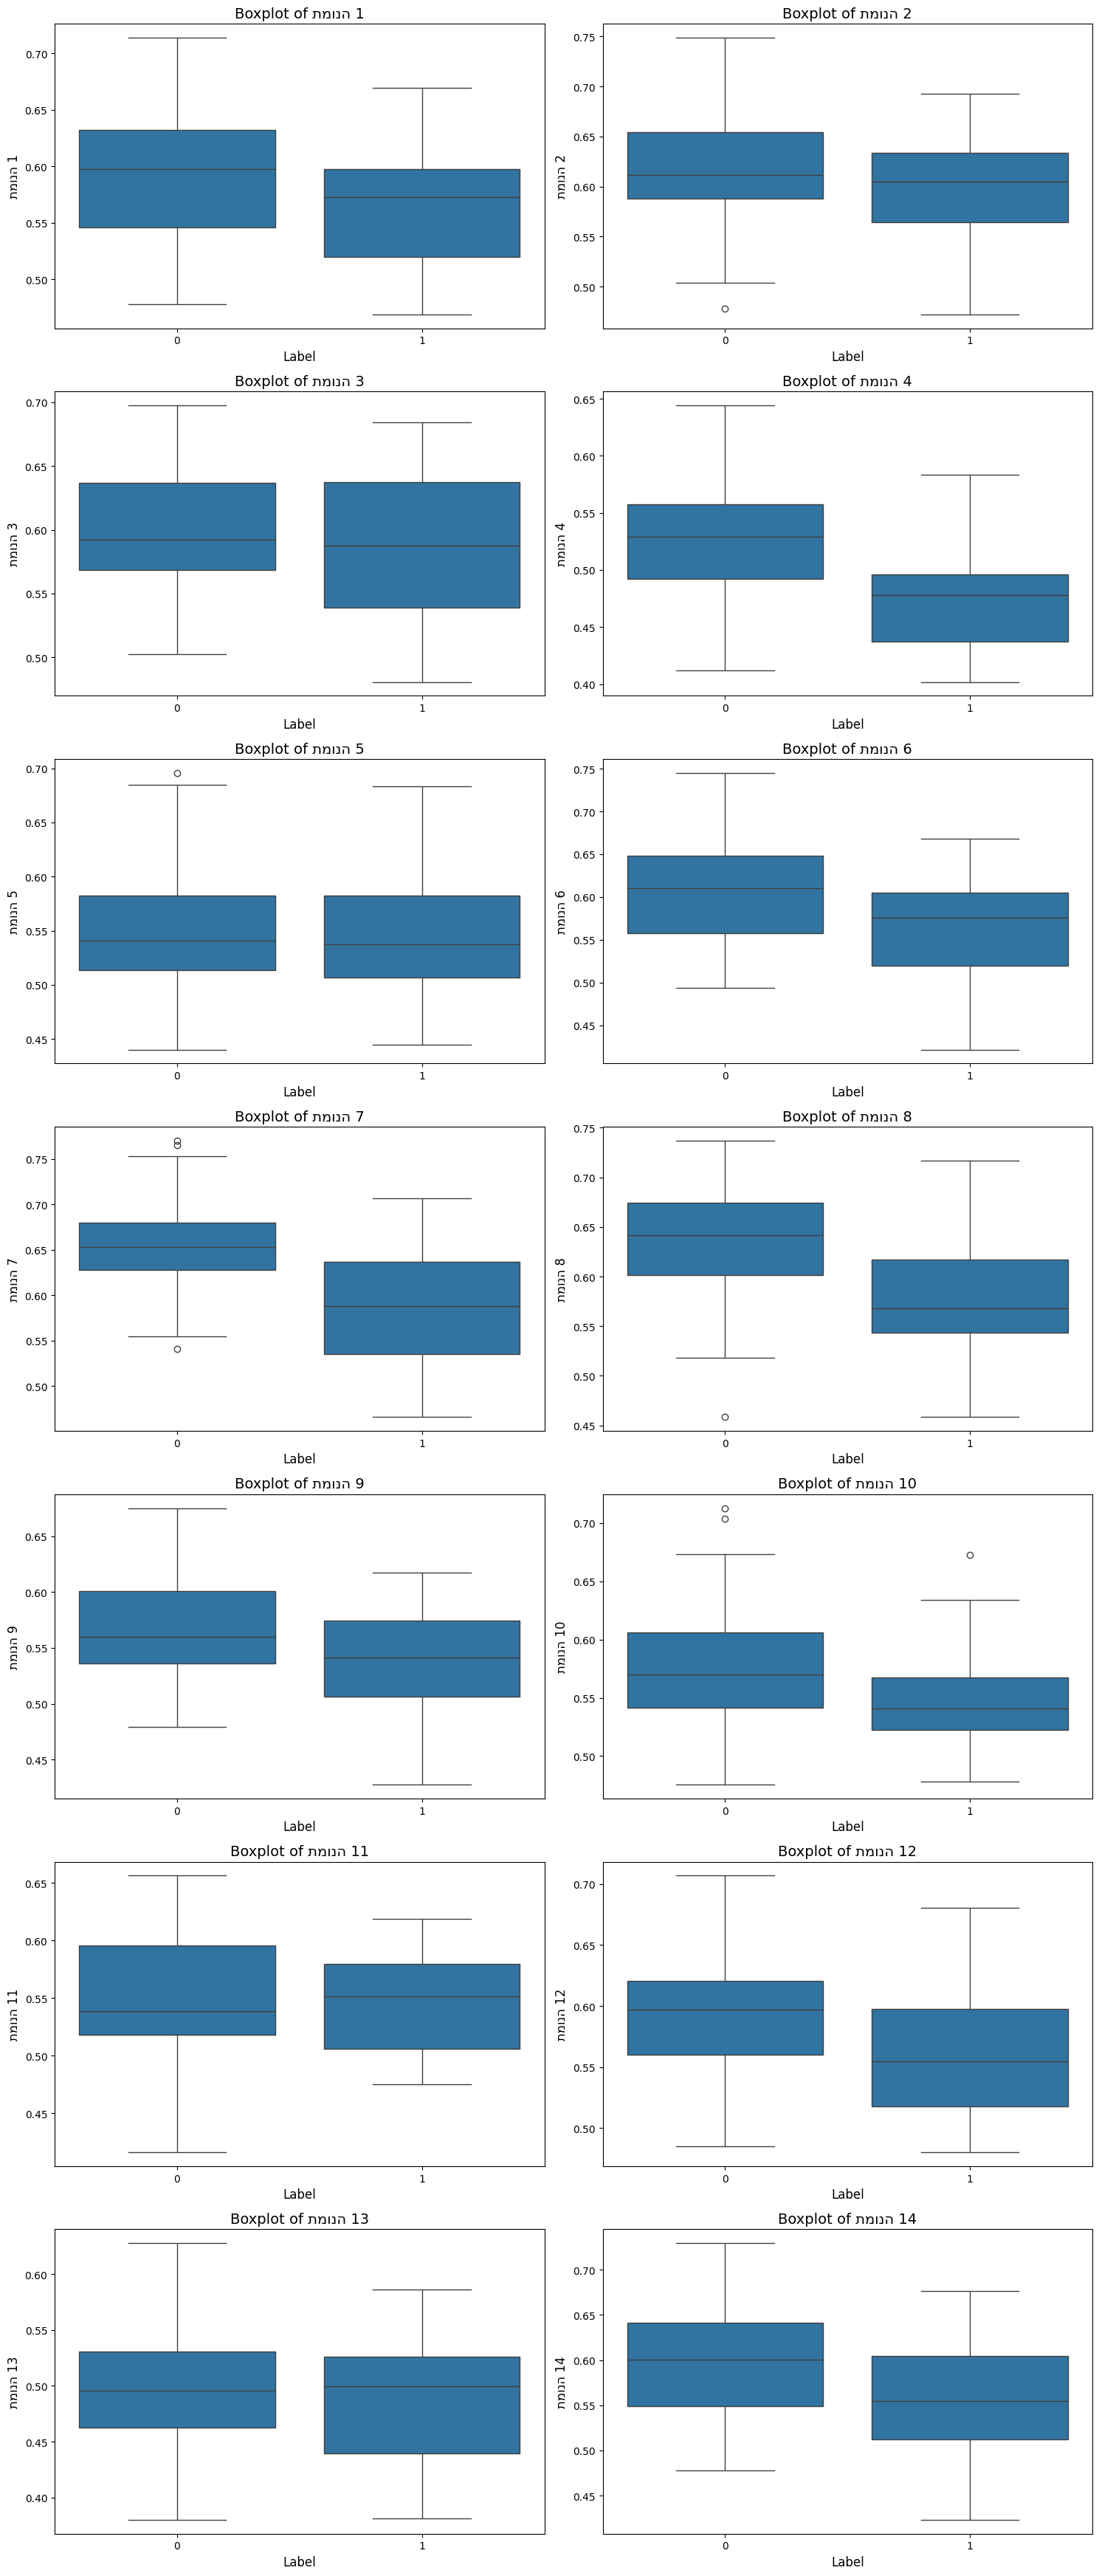

In [131]:
df = distances_df.copy()

# Create a grid of boxplots
features = df.columns.drop('label')  # Exclude the 'label' column

# Determine the number of rows and columns for the grid
num_features = len(features)
num_cols = 2
num_rows = (num_features + 1) // num_cols

# Increase the figure size for better visibility
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten axes array if there are multiple rows
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.boxplot(x='label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel('Label', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=12)

# Remove any empty subplots (if the number of features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# t-test

In [132]:
# Significance level
alpha = 0.05
successful_columns_ttest = []
# Loop through each column and perform t-test
for col in distances_df.columns[:-1]:  # Exclude 'label'
    group_0 = distances_df[distances_df['label'] == 0][col]
    group_1 = distances_df[distances_df['label'] == 1][col]
    
    # Perform t-test
    t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
    
    # Hypothesis and conclusion
    print(f"\nTesting {col}:")
    print("Null Hypothesis: The means of the two groups (label = 0 and label = 1) are equal.")
    print("Alternative Hypothesis: The means of the two groups are different.")
    
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
    
    if p_val < alpha:
        print(f"Result: Reject the null hypothesis (p < {alpha}). The feature '{col}' has a statistically significant effect on the label.\n")
        successful_columns_ttest.append(col)  # Save successful column name
    else:
        print(f"Result: Fail to reject the null hypothesis (p >= {alpha}). The feature '{col}' does not have a statistically significant effect on the label.\n")

print("\nSuccessful Columns:", successful_columns_ttest)


Testing תמונה 1:
Null Hypothesis: The means of the two groups (label = 0 and label = 1) are equal.
Alternative Hypothesis: The means of the two groups are different.
T-statistic: 2.0448, P-value: 0.0486
Result: Reject the null hypothesis (p < 0.05). The feature 'תמונה 1' has a statistically significant effect on the label.


Testing תמונה 2:
Null Hypothesis: The means of the two groups (label = 0 and label = 1) are equal.
Alternative Hypothesis: The means of the two groups are different.
T-statistic: 1.5841, P-value: 0.1226
Result: Fail to reject the null hypothesis (p >= 0.05). The feature 'תמונה 2' does not have a statistically significant effect on the label.


Testing תמונה 3:
Null Hypothesis: The means of the two groups (label = 0 and label = 1) are equal.
Alternative Hypothesis: The means of the two groups are different.
T-statistic: 1.1673, P-value: 0.2525
Result: Fail to reject the null hypothesis (p >= 0.05). The feature 'תמונה 3' does not have a statistically significant eff

# Logistic Regression

In [133]:
import statsmodels.api as sm

# Logistic Regression
X = distances_df.drop(columns='label')
y = distances_df['label']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model on the training set
model = sm.Logit(y_train, X_train).fit()


# Hypotheses and significance tracking
alpha = 0.15
successful_columns_logistic_regression = []  

print("\nHypotheses for Logistic Regression:")
print("Null Hypothesis: The coefficient of a feature is zero (no effect on the label).")
print("Alternative Hypothesis: The coefficient of a feature is not zero (the feature affects the label).")

# Extract p-values from the model summary
p_values = model.pvalues

for feature, p_val in p_values.items():
    print(f"\nFeature: {feature}, P-value: {p_val:.4f}")
    
    if p_val < alpha:
        print(f"Result: Reject the null hypothesis (p < {alpha}). The feature '{feature}' has a statistically significant effect on the label.")
        successful_columns_logistic_regression.append(feature)  # Save successful column name
    else:
        print(f"Result: Fail to reject the null hypothesis (p >= {alpha}). The feature '{feature}' does not have a statistically significant effect on the label.")

print("\nSuccessful Columns:", successful_columns_logistic_regression)

Optimization terminated successfully.
         Current function value: 0.224326
         Iterations 9

Hypotheses for Logistic Regression:
Null Hypothesis: The coefficient of a feature is zero (no effect on the label).
Alternative Hypothesis: The coefficient of a feature is not zero (the feature affects the label).

Feature: const, P-value: 0.1540
Result: Fail to reject the null hypothesis (p >= 0.15). The feature 'const' does not have a statistically significant effect on the label.

Feature: תמונה 1, P-value: 0.8292
Result: Fail to reject the null hypothesis (p >= 0.15). The feature 'תמונה 1' does not have a statistically significant effect on the label.

Feature: תמונה 2, P-value: 0.0836
Result: Reject the null hypothesis (p < 0.15). The feature 'תמונה 2' has a statistically significant effect on the label.

Feature: תמונה 3, P-value: 0.5085
Result: Fail to reject the null hypothesis (p >= 0.15). The feature 'תמונה 3' does not have a statistically significant effect on the label.

F

In [134]:
# Print the model summary
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   56
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                           14
Date:                Thu, 29 Aug 2024   Pseudo R-squ.:                  0.6140
Time:                        12:57:10   Log-Likelihood:                -12.562
converged:                       True   LL-Null:                       -32.542
Covariance Type:            nonrobust   LLR p-value:                 0.0002588
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5730     14.430      1.426      0.154      -7.710      48.856
תמונה 1       -3.1990     14.831     -0.216      0.829     -32.268      25.870
תמונה 2       39.4592     22.805      1.730      0.0

In [135]:
# Extracting model coefficients
print("\nModel Coefficients:")
print(model.params)


Model Coefficients:
const       20.572951
תמונה 1     -3.198959
תמונה 2     39.459232
תמונה 3    -12.998308
תמונה 4    -38.751757
תמונה 5     -3.668778
תמונה 6     -8.444248
תמונה 7    -44.993783
תמונה 8    -12.715932
תמונה 9    -44.588035
תמונה 10    -4.930941
תמונה 11    60.165259
תמונה 12    17.930937
תמונה 13    35.489279
תמונה 14   -13.359976
dtype: float64


In [136]:
# Confidence intervals of coefficients
print("\nConfidence Intervals for Coefficients:")
print(model.conf_int())



Confidence Intervals for Coefficients:
                  0           1
const     -7.710077   48.855980
תמונה 1  -32.267735   25.869817
תמונה 2   -5.237930   84.156394
תמונה 3  -51.526860   25.530243
תמונה 4  -78.420398    0.916883
תמונה 5  -43.029157   35.691601
תמונה 6  -31.589768   14.701273
תמונה 7  -93.337777    3.350210
תמונה 8  -46.784342   21.352477
תמונה 9  -97.224999    8.048930
תמונה 10 -49.395825   39.533944
תמונה 11  -4.744845  125.075362
תמונה 12 -31.673780   67.535654
תמונה 13  -7.843545   78.822103
תמונה 14 -37.960615   11.240663


In [137]:

# Model performance on the training set
print("\n--- Training Set Performance ---")

# Training set predictions and evaluation
train_pred_probs = model.predict(X_train)
train_pred = (train_pred_probs > 0.5).astype(int)

# Classification report for training set
print("\nTraining Set Classification Report:")
print(classification_report(y_train, train_pred))

# Model performance on the test set
print("\n--- Test Set Performance ---")

# Test set predictions and evaluation
test_pred_probs = model.predict(X_test)
test_pred = (test_pred_probs > 0.5).astype(int)

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_pred))




--- Training Set Performance ---

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.81      0.87      0.84        15

    accuracy                           0.91        56
   macro avg       0.88      0.90      0.89        56
weighted avg       0.91      0.91      0.91        56


--- Test Set Performance ---

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.57      0.67      0.62         6

    accuracy                           0.79        24
   macro avg       0.73      0.75      0.74        24
weighted avg       0.80      0.79      0.80        24



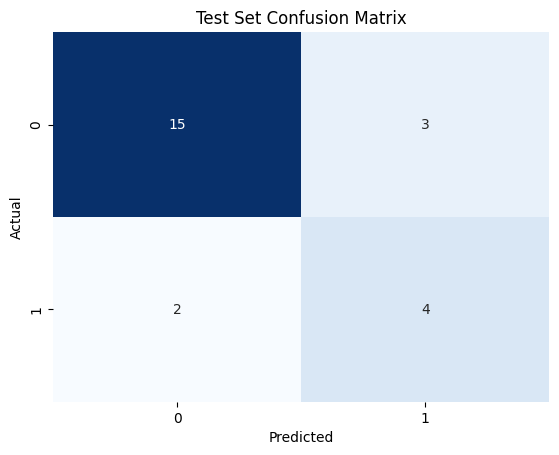

In [138]:

# Test Set: Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




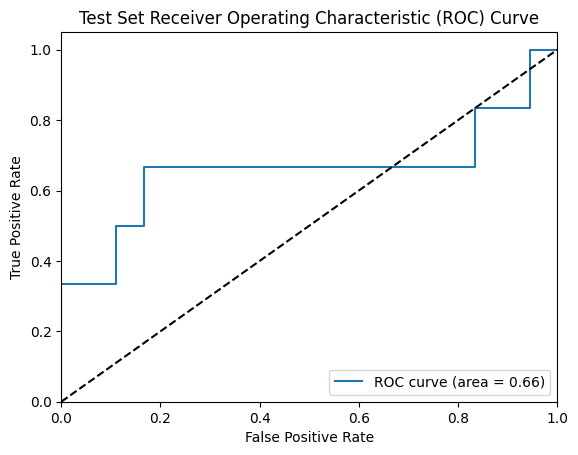

In [139]:
# Test Set: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_pred_probs)
roc_auc = roc_auc_score(y_test, test_pred_probs)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

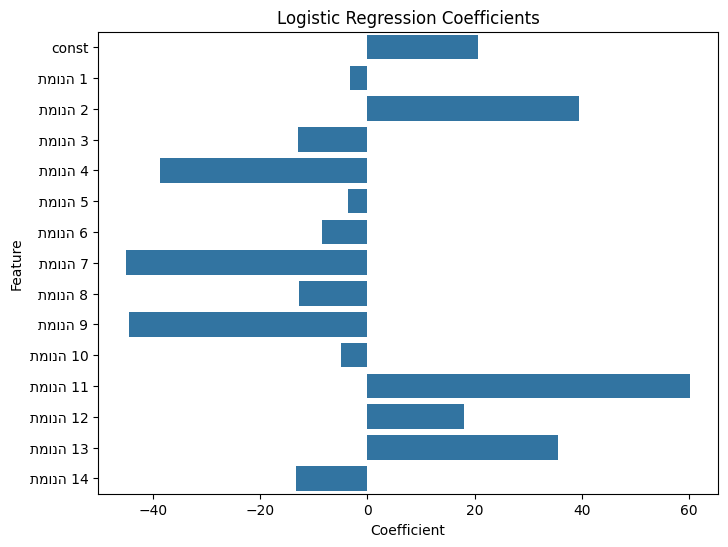

In [140]:
# Plot Coefficients
coef_df = pd.DataFrame({
    'Feature': model.params.index,
    'Coefficient': model.params.values
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Logistic Regression Coefficients')
plt.show()

# correlation matrix

In [141]:

# Compute correlation matrix
corr_matrix = distances_df.corr()

print("Hypothesis for Correlation Test:")
print("Null Hypothesis: There is no correlation between the feature and the label.")
print("Alternative Hypothesis: There is a correlation between the feature and the label.")

# Extract correlation with label
corr_with_label = corr_matrix['label'].sort_values(ascending=False)

# Threshold for moderate correlation
threshold = 0.3

# List to store the names of features with significant correlation
significant_features_corr_matrix = []

# Loop over correlations
for feature, corr_value in corr_with_label.items():
    if feature == 'label':
        continue  # Skip self-correlation
    
    print(f"\nFeature: {feature}, Correlation: {corr_value:.4f}")
    
    # Hypothesis test result
    if abs(corr_value) > threshold:
        print(f"Result: Reject the null hypothesis. There is a significant correlation between {feature} and the label.")
        significant_features_corr_matrix.append(feature)
    else:
        print(f"Result: Fail to reject the null hypothesis. There is no significant correlation between {feature} and the label.")

print(f"\nSignificant Features: {significant_features_corr_matrix}")

Hypothesis for Correlation Test:
Null Hypothesis: There is no correlation between the feature and the label.
Alternative Hypothesis: There is a correlation between the feature and the label.

Feature: תמונה 5, Correlation: -0.0389
Result: Fail to reject the null hypothesis. There is no significant correlation between תמונה 5 and the label.

Feature: תמונה 11, Correlation: -0.0529
Result: Fail to reject the null hypothesis. There is no significant correlation between תמונה 11 and the label.

Feature: תמונה 13, Correlation: -0.1250
Result: Fail to reject the null hypothesis. There is no significant correlation between תמונה 13 and the label.

Feature: תמונה 3, Correlation: -0.1460
Result: Fail to reject the null hypothesis. There is no significant correlation between תמונה 3 and the label.

Feature: תמונה 2, Correlation: -0.1813
Result: Fail to reject the null hypothesis. There is no significant correlation between תמונה 2 and the label.

Feature: תמונה 1, Correlation: -0.2283
Result: Fa

# columns_to_evaluate

In [142]:
successful_columns_ttest


['תמונה 1',
 'תמונה 4',
 'תמונה 6',
 'תמונה 7',
 'תמונה 8',
 'תמונה 9',
 'תמונה 10',
 'תמונה 12',
 'תמונה 14']

In [143]:
successful_columns_logistic_regression

['תמונה 2', 'תמונה 4', 'תמונה 7', 'תמונה 9', 'תמונה 11', 'תמונה 13']

In [144]:
significant_features_corr_matrix

['תמונה 9', 'תמונה 14', 'תמונה 6', 'תמונה 4', 'תמונה 8', 'תמונה 7']

In [145]:


# Get all the columns except 'label'
columns_to_evaluate = distances_df.columns.drop('label')

# Create the summary DataFrame for those columns
summary_df = pd.DataFrame(index=columns_to_evaluate)

# Fill in results for each test
summary_df['ttest_success'] = summary_df.index.isin(successful_columns_ttest)
summary_df['logistic_regression_success'] = summary_df.index.isin(successful_columns_logistic_regression)
summary_df['correlation_matrix_success'] = summary_df.index.isin(significant_features_corr_matrix)

# Convert boolean values to 'Yes'/'No' for better readability
summary_df = summary_df.replace({True: 'Yes', False: 'No'})

print(summary_df)

         ttest_success logistic_regression_success correlation_matrix_success
תמונה 1            Yes                          No                         No
תמונה 2             No                         Yes                         No
תמונה 3             No                          No                         No
תמונה 4            Yes                         Yes                        Yes
תמונה 5             No                          No                         No
תמונה 6            Yes                          No                        Yes
תמונה 7            Yes                         Yes                        Yes
תמונה 8            Yes                          No                        Yes
תמונה 9            Yes                         Yes                        Yes
תמונה 10           Yes                          No                         No
תמונה 11            No                         Yes                         No
תמונה 12           Yes                          No              

/var/folders/qw/xg8gc9qd673350wtlpq7lzmm0000gn/T/ipykernel_19695/3405560470.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = summary_df.replace({'Yes': 1, 'No': 0})


Text(70.72222222222221, 0.5, 'Features')

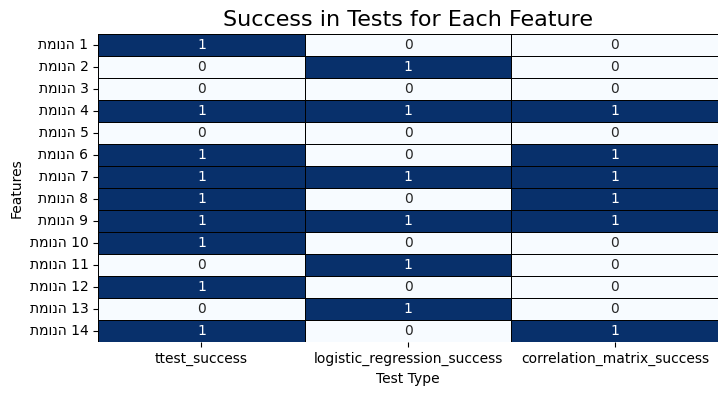

In [146]:
# Convert 'Yes'/'No' to 1 and 0 for better plotting
plot_df = summary_df.replace({'Yes': 1, 'No': 0})

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(plot_df, annot=True, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

# Add labels and title
plt.title('Success in Tests for Each Feature', fontsize=16)
plt.xlabel('Test Type')
plt.ylabel('Features')